## MI-PAA, Úloha 4: Seznámení se se zvolenou pokročilou iterativní metodou na problému batohu

**Marián Hlaváč**, 17 Dec 2017 (hlavam30)  
marian.hlavac@fit.cvut.cz  
https://github.com/mmajko/knapsack-problem

## Zadání úlohy

- Zvolte si heuristiku, kterou budete řešit problém vážené splnitelnosti booleovské formule (simulované ochlazování, simulovaná evoluce, tabu prohledávání)
- Tuto heuristiku použijte pro řešení problému batohu. Můžete použít dostupné instance problému (zde), anebo si vygenerujte své instance pomocí generátoru. Používejte instance s větším počtem věcí (>30).
- Hlavním cílem domácí práce je seznámit se s danou heuristikou, zejména se způsobem, jakým se nastavují její parametry (rozvrh ochlazování, selekční tlak, tabu lhůta…) a modifikace (zjištění počáteční teploty, mechanismus slekce, tabu atributy…). Není-li Vám cokoli jasné, prosíme ptejte se na cvičeních.
- Problém batohu není příliš obtížný, většinou budete mít k dispozici globální maxima (exaktní řešení) z předchozích prací, například z dynamického programování. Závěrečná úloha je co do nastavení a požadovaného výkonu heuristiky podstatně náročnější a může vyžadovat zcela jiné nastavení parametrů.




## Popis postupu řešení

Vybral jsem si k vypracování **Genetický algoritmus**.

### Kostra algoritmu

Celý algoritmus je k nahlédnutí ve [zdrojových souborech programu na GitHubu](https://github.com/mmajko/knapsack-problem). Pro rychlou představu je níže uveden úryvek z funkce, která řídí evoluci.

```rust
...
// Run for a number of generations
    for i in 0..500 {
        let mut sorted_population = sort_population(&population, fitness_fn);
        
        // Selection
        let mut new_population = selectors::tournament(&population, tournament_count, 
            tournament_pool_size, fitness_fn);
        
        // Elitism
        sorted_population.truncate(tournament_count);
        new_population.append(&mut sorted_population);
        
        // Fill the rest of population with offsprings
        while new_population.len() != pop_size {
            let mut child: Vec<bool>;
            
            // Mate or select a random individual
            if odds_are(xover_probability) {
                // Select two random individuals
                let in1 = random_individual(&new_population).clone();
                let in2 = random_individual(&new_population).clone();
                
...
```

Jako typ selekce jsem vybral **turnajovou selekci**, zároveň využívám čistého **elitismu** a do nových populací přenáším určitý počet nejlepších jedinců. S určitou pravděpodobností pak používám **single-point křížení**, dále s určitou pravděpodobností **náhodnou mutaci** (inverze bitů s pravděpodobností). Nevalidní řešení jsou zahazovány.

## Hledání nejlepších parametrů.

Postupně jsem každý parametr nastavoval a sledoval, jak se vyvíjí kvalita celé populace. Postupným nastavováním parametrů jsem pak našel přibližně nejlepší nastavení parametrů, které vedlo k rychlé konvergenci k nejlepšímu výsledku.

### Jak číst v grafech

Data pro grafy byly ukládany automaticky, takže jejich křivky jsou pojmenovány velmi zvláštně. Dá se z nich však velmi jednoduše vyčíst nastavení parametrů programu. Každý parametr je označen písmenem (např. x pro crossover) a za ním následuje číselná hodnota, která je podle povahy parametru celé číslo nebo číslo s desetinnou částí.

Celý řetězec tak označuje nastavení:

> **x**XX**m**XX**e**X**t**X**p**X

- **x** pravděpodobnost křízení (00 - 09, 0.0 až 0.9)
- **m** pravděpodobnost mutace (00 - 09, 0.0 až 0.9)
- **e** elitismus (velikost přenesené populace do nové)
- **t** počet turnajů
- **p** velikost turnaje

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob

# Konfigurace vizualizace dat
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 15

def read_results(pattern):
    data = pd.DataFrame({})
    for file in glob.glob(pattern):
        raw = pd.read_csv(file)
        if (data.empty):
            data = raw
        else:
            data = data.merge(raw, left_index=True, right_index=True)
    return data

optimum_price = 4068

### Velikost šumu

Nejdříve jsem spustil stejné nastavení parametrů několikrát za sebou, abych zjistil, k jak velkým rozdílům mezi průběhy dochází, díky náhodnosti.

Na grafu je vidět, že jde o velké výkyvy a tak je potřeba data zkoumat velmi obezřetně a uvádět závěry opatrně.

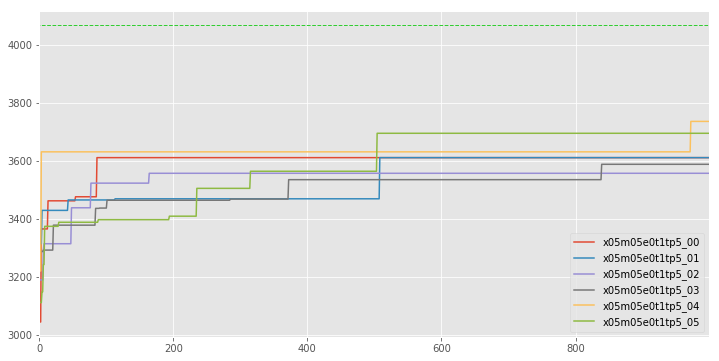

In [35]:
ax = read_results("data/evo-results/00-*.dat").plot()
ax.axhline(y=optimum_price, xmin=-1, xmax=1, color='limegreen', linestyle='--', lw=1)

### Pravděpodobnost křížení

Jako první jsem zkusil najít nejlepší parametr pravděpodobnosti křížení.

Nebylo to jednoduché, z grafu to příliš poznat nešlo, ale subjektivně hodnotím `0.4` jako nejlepší hodnotu pravděpodobnosti křížení.

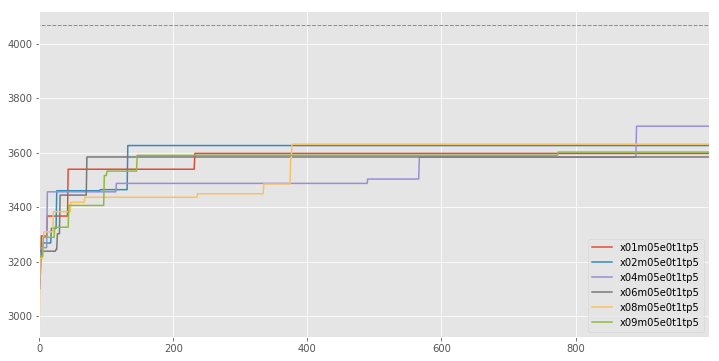

In [37]:
ax = read_results("data/evo-results/01-*.dat").plot()
ax.axhline(y=optimum_price, xmin=-1, xmax=1, color='limegreen', linestyle='--', lw=1)

### Pravděpodobnost mutace

Pravděpodobnost mutace je parametr, který je nutné udržovat přiměřeně nízký, aby se nám spočítaná kvalitní řešení neničila.

Na grafu je to velmi zřejmě vidět.

Nejlepší hodnota se ukázala jako `0.1`.

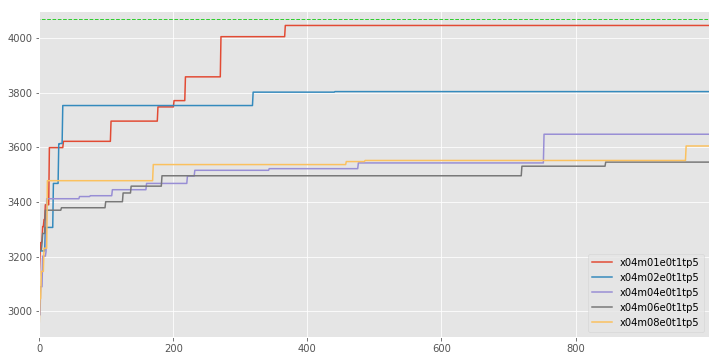

In [40]:
ax = read_results("data/evo-results/02-*.dat").plot()
ax.axhline(y=optimum_price, xmin=-1, xmax=1, color='limegreen', linestyle='--', lw=1)

### Elitismus

Dávání přednost nejlepším jedincům znevýhodňuje slabší jedice, kteří však v sobě mohou nést lepší informaci. 

Vysoká hodnota často způsobí uváznutí v lokálním minimu.

Jako nejlepší nastavení parametru hodnotím přenesení dvou nejlepších jedinců do nové populace.

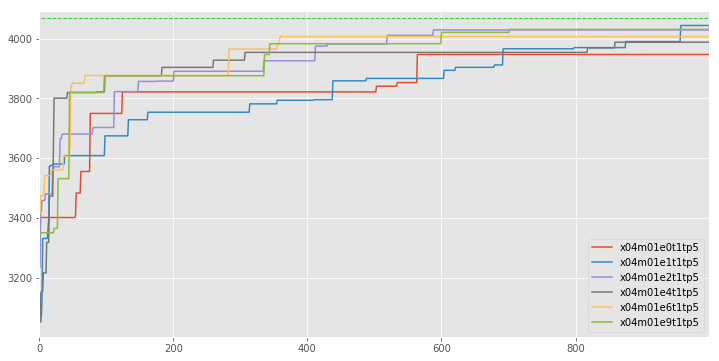

In [43]:
ax = read_results("data/evo-results/03-*.dat").plot()
ax.axhline(y=optimum_price, xmin=-1, xmax=1, color='limegreen', linestyle='--', lw=1)

### Velikost turnaje

Turnajem se vybírají jedinci ke křížení. Do každého turnaje vstupuje několik náhodných jedinců z celé populace.

Tento parametr se chová obdobně, jako elitimus, při velkých turnajích jsou znevýhodněni slabší jedinci.

Jako nejlepší hodnota se jeví turnaj o velikosti `2`.



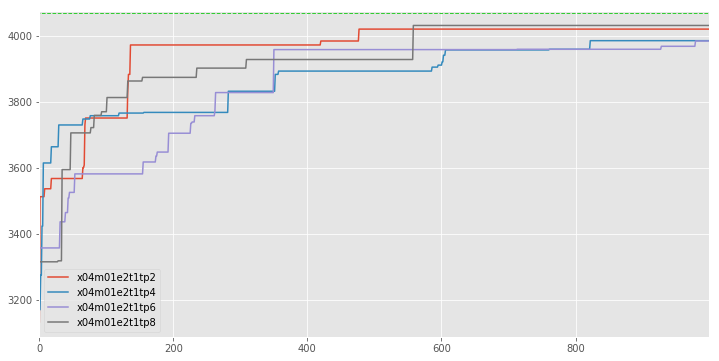

In [44]:
ax = read_results("data/evo-results/04-*.dat").plot()
ax.axhline(y=optimum_price, xmin=-1, xmax=1, color='limegreen', linestyle='--', lw=1)

### Počet turnajů

Turnajem se vybírají jedinci ke křížení. Z každého turnaje je vybírán vždy jeden, tudíž počet turnajů nepřímo určuje, kolik jedinců bude vybráno ke křížení do nové populace.

Rychlejší průběh poskytly spíše větší počty turnajů.

Jako nejlepší nastavení jsem zhodnotil nastavení počtu turnajů na `24`. 


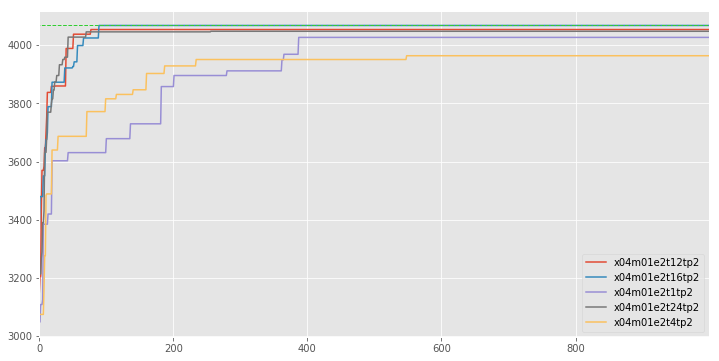

In [50]:
ax = read_results("data/evo-results/05-*.dat").plot()
ax.axhline(y=optimum_price, xmin=-1, xmax=1, color='limegreen', linestyle='--', lw=1)

### Největší nutný počet generací

Posledním experimentem jsem zjišťoval, kolik nejméně generací je potřeba, dokud nedojde ke konvergenci, pro instance s 30 předměty.

I s velkou rezervou jsem vybral hodnotu `500` generací, jako vhodný moment k ukončení evoluce.

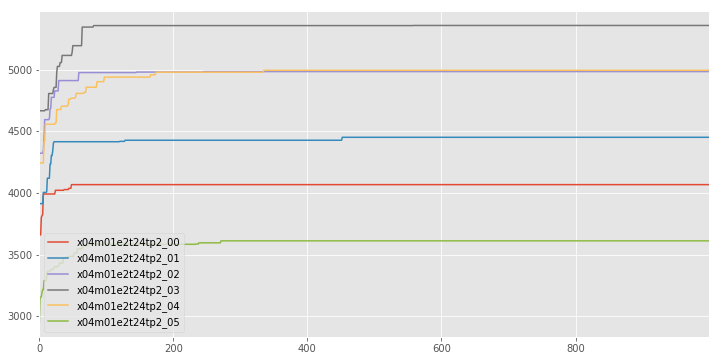

In [53]:
ax = read_results("data/evo-results/06-*.dat").plot()

## Závěr

Spustil jsem program i pro instance s více předměty.

In [54]:
data = pd.read_csv("data/evo-results/results.csv")
data

,knap_id,method,item_count,price,elapsed_ms
0,9350,Evolution,30,2875,211
1,9351,Evolution,30,3327,188
2,9352,Evolution,30,3463,195
3,9353,Evolution,30,3987,188
4,9354,Evolution,30,3771,188
5,9355,Evolution,30,3950,185
6,9356,Evolution,30,3757,179
...,...,...,...,...,...
143,9593,Evolution,40,4993,253
144,9594,Evolution,40,4212,264


Pokročilá iterativní metoda je nesmírně efektivní při velkých počtech předmětů v instanci.

Přesnost se pohybuje kolem 90-100% (tj, relativní chyba většinou menší, než 10%) a čas strávený výpočtem je několikařádově menší, než při použití jiných metod.

Níže je vidět tabulka průměrných dob trvání pro různé počty předmětů:

In [59]:
data.groupby('item_count').mean()[['elapsed_ms']]

,elapsed_ms
item_count,
30,187.08
35,208.88
40,262.56


A pro srovnání s předchozími metody uvádím tabulku přibližného porovnání, kolik by stálo času vypočítat instanci se 40 předměty jinými metodami.

**Pro 40 předmětů v batohu:**

Metoda | Čas
-- | --
Rekruzvivní | 43 hodin (odhadem)
Dynamic | 122 minut (odhadem)
Evoluční | 262 ms


Implementace byla úspěšná a napsána pro jednoduché nahrazení problémem batohu za SAT. Osobně jsem zvědav, jak se budou výsledky lišit pro jiný problém, než je problém batohu.